# 시카고 범죄율을 예측해 보자 ( Facebook 의 Prophet 라이브러리 활용 )





# STEP #0: PROBLEM STATEMENT

- The Chicago Crime dataset : 2001 ~ 2017.
- Datasource: 캐글 https://www.kaggle.com/currie32/crimes-in-*chicago*
- Dataset contains the following columns:
    - ID: Unique identifier for the record.
    - Case Number: The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
    - Date: Date when the incident occurred.
    - Block: address where the incident occurred
    - IUCR: The Illinois Unifrom Crime Reporting code.
    - Primary Type: The primary description of the IUCR code.
    - Description: The secondary description of the IUCR code, a subcategory of the primary description.
    - Location Description: Description of the location where the incident occurred.
    - Arrest: Indicates whether an arrest was made.
    - Domestic: Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
    - Beat: Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car.
    - District: Indicates the police district where the incident occurred.
    - Ward: The ward (City Council district) where the incident occurred.
    - Community Area: Indicates the community area where the incident occurred. Chicago has 77 community areas.
    - FBI Code: Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS).
    - X Coordinate: The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection.
    - Y Coordinate: The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection.
    - Year: Year the incident occurred.
    - Updated On: Date and time the record was last updated.
    - Latitude: The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Longitude: The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
    - Location: The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.


### 페이스북에서 만든 오픈소스 Prophet 라이브러리

- Seasonal time series data를 분석할 수 있는 딥러닝 라이브러리다.

- 프로펫 공식 레이지 : https://research.fb.com/prophet-forecasting-at-scale/
https://facebook.github.io/prophet/docs/quick_start.html#python-api


### 코랩에는 자동으로 prophet이 설치되어 있다. 따라서 다른 환경에서 설치 되어있지 않다면, 다음처럼 설치하면 된다.

- pip install prophet
     
- 위의 pip 설치 시 에러가 나면 다음처럼 설치해 준다 :
    conda install -c conda-forge prophet


# STEP #1: IMPORTING DATA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from prophet import Prophet


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chicago_Crimes_2005_to_2007.csv
# Chicago_Crimes_2008_to_2011.csv
# Chicago_Crimes_2012_to_2017.csv 파일을 읽되,
# 각각 파라미터 on_bad_lines='skip' 추가 해준다.


In [8]:
pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml_plus/data/Chicago_Crimes_2005_to_2007.csv', on_bad_lines='skip')

,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
3,4,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
4,5,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872338,6254263,4673620,HM269120,04/04/2006 10:00:00 AM,002XX N KOLMAR AVE,0460,BATTERY,SIMPLE,"SCHOOL, PUBLIC, BUILDING",False,...,28.0,26.0,08B,1146037.0,1900783.0,2006,04/15/2016 08:55:02 AM,41.883735,-87.739200,"(41.883734918, -87.739199887)"
1872339,6254264,4673621,HM272803,04/04/2006 05:30:00 PM,034XX N MAJOR AVE,1340,CRIMINAL DAMAGE,TO STATE SUP PROP,"SCHOOL, PUBLIC, BUILDING",False,...,38.0,15.0,14,1137757.0,1922269.0,2006,04/15/2016 08:55:02 AM,41.942848,-87.769086,"(41.942848288, -87.769086168)"
1872340,6254265,4673622,HM271989,04/04/2006 06:40:30 PM,081XX S ELLIS AVE,0430,BATTERY,AGGRAVATED: OTHER DANG WEAPON,VACANT LOT/LAND,False,...,8.0,44.0,04B,1184311.0,1851174.0,2006,04/15/2016 08:55:02 AM,41.746791,-87.600210,"(41.746791148, -87.600209768)"
1872341,6254266,4673623,HM271676,04/04/2006 03:50:00 PM,057XX S COTTAGE GROVE AVE,0460,BATTERY,SIMPLE,STREET,False,...,5.0,41.0,08B,1182559.0,1867082.0,2006,04/15/2016 08:55:02 AM,41.790485,-87.606137,"(41.79048504, -87.606136634)"


In [10]:
chicago_df_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml_plus/data/Chicago_Crimes_2005_to_2007.csv', on_bad_lines='skip')
chicago_df_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml_plus/data/Chicago_Crimes_2008_to_2011.csv', on_bad_lines='skip')
chicago_df_3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml_plus/data/Chicago_Crimes_2012_to_2017.csv', on_bad_lines='skip')

In [16]:
# 데이터 모양을 보고, 이상한 부분은 처리해 준다.
chicago_df_1.drop('Unnamed: 0' , axis = 1, inplace = True)

In [17]:
chicago_df_2.drop('Unnamed: 0' , axis = 1, inplace = True)

In [18]:
chicago_df_3.drop('Unnamed: 0' , axis = 1, inplace = True)

In [19]:
# 위의 3개 데이터프레임을 하나로 합친다.

chicago_df =  pd.concat([chicago_df_1, chicago_df_2, chicago_df_3])


In [20]:
chicago_df

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,4673626,HM274058,04/02/2006 01:00:00 PM,055XX N MANGO AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,...,45.0,11.0,26,1136872.0,1936499.0,2006,04/15/2016 08:55:02 AM,41.981913,-87.771996,"(41.981912692, -87.771996382)"
1,4673627,HM202199,02/26/2006 01:40:48 PM,065XX S RHODES AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,...,20.0,42.0,18,1181027.0,1861693.0,2006,04/15/2016 08:55:02 AM,41.775733,-87.611920,"(41.775732538, -87.611919814)"
2,4673628,HM113861,01/08/2006 11:16:00 PM,013XX E 69TH ST,051A,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,...,5.0,69.0,04A,1186023.0,1859609.0,2006,04/15/2016 08:55:02 AM,41.769897,-87.593671,"(41.769897392, -87.593670899)"
3,4673629,HM274049,04/05/2006 06:45:00 PM,061XX W NEWPORT AVE,0460,BATTERY,SIMPLE,RESIDENCE,False,False,...,38.0,17.0,08B,1134772.0,1922299.0,2006,04/15/2016 08:55:02 AM,41.942984,-87.780057,"(41.942984005, -87.780056951)"
4,4673630,HM187120,02/17/2006 09:03:14 PM,037XX W 60TH ST,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,...,13.0,65.0,18,1152412.0,1864560.0,2006,04/15/2016 08:55:02 AM,41.784211,-87.716745,"(41.784210853, -87.71674491)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456709,10508679,HZ250507,05/03/2016 11:33:00 PM,026XX W 23RD PL,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,...,28.0,30.0,08B,1159105.0,1888300.0,2016,05/10/2016 03:56:50 PM,41.849222,-87.691556,"(41.849222028, -87.69155551)"
1456710,10508680,HZ250491,05/03/2016 11:30:00 PM,073XX S HARVARD AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,...,17.0,69.0,14,1175230.0,1856183.0,2016,05/10/2016 03:56:50 PM,41.760744,-87.633335,"(41.760743949, -87.63333531)"
1456711,10508681,HZ250479,05/03/2016 12:15:00 AM,024XX W 63RD ST,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,...,15.0,66.0,04B,1161027.0,1862810.0,2016,05/10/2016 03:56:50 PM,41.779235,-87.685207,"(41.779234743, -87.685207125)"
1456712,10508690,HZ250370,05/03/2016 09:07:00 PM,082XX S EXCHANGE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,...,7.0,46.0,08B,1197261.0,1850727.0,2016,05/10/2016 03:56:50 PM,41.745252,-87.552773,"(41.745251975, -87.552773464)"


# STEP #2: EXPLORING THE DATASET  

In [ ]:
# Let's view the head of the training dataset


In [ ]:
# Let's view the last elements in the training dataset


### 비어있는 데이터가 얼마나 되는지 확인하시오.

In [21]:
chicago_df.isna().sum()

ID                          0
Case Number                 7
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     1974
Arrest                      0
Domestic                    0
Beat                        0
District                   89
Ward                       92
Community Area           1844
FBI Code                    0
X Coordinate            74882
Y Coordinate            74882
Year                        0
Updated On                  0
Latitude                74882
Longitude               74882
Location                74882
dtype: int64

### 다음 컬럼들을 삭제하시오.

'Case Number', 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude'

In [22]:
cols = [ 'Case Number', 'IUCR', 'X Coordinate', 'Y Coordinate','Updated On','Year', 'FBI Code', 'Beat','Ward','Community Area', 'Location', 'District', 'Latitude' , 'Longitude']

In [23]:
chicago_df.drop(cols, axis = 1, inplace = True)

In [24]:
chicago_df.head(3)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,4673626,04/02/2006 01:00:00 PM,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,4673627,02/26/2006 01:40:48 PM,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,4673628,01/08/2006 11:16:00 PM,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False


### Date 컬럼을 보니, 날짜 형식으로 되어있다. 이를 파이썬이 이해할 수 있는 날짜로 바꿔서 다시 Date 컬럼에 저장하시오.

In [25]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6017767 entries, 0 to 1456713
Data columns (total 8 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   ID                    int64 
 1   Date                  object
 2   Block                 object
 3   Primary Type          object
 4   Description           object
 5   Location Description  object
 6   Arrest                bool  
 7   Domestic              bool  
dtypes: bool(2), int64(1), object(5)
memory usage: 332.9+ MB


In [27]:
chicago_df['Date'][0]

0    04/02/2006 01:00:00 PM
0    10/07/2008 12:39:00 PM
0    05/03/2016 11:40:00 PM
Name: Date, dtype: object

In [28]:
chicago_df['Date'] = pd.to_datetime( chicago_df['Date'] , format='%m/%d/%Y %I:%M:%S %p' )

In [29]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False
2,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False
3,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False
4,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False
...,...,...,...,...,...,...,...,...
1456709,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True
1456710,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True
1456711,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False
1456712,10508690,2016-05-03 21:07:00,082XX S EXCHANGE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True


In [30]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6017767 entries, 0 to 1456713
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Date                  datetime64[ns]
 2   Block                 object        
 3   Primary Type          object        
 4   Description           object        
 5   Location Description  object        
 6   Arrest                bool          
 7   Domestic              bool          
dtypes: bool(2), datetime64[ns](1), int64(1), object(4)
memory usage: 397.4+ MB


In [31]:
chicago_df.head(2)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic
0,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False
1,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False


In [36]:
chicago_df.iloc[ 0 , 1 ]

Timestamp('2006-04-02 13:00:00')

In [39]:
chicago_df['weekday'] = chicago_df['Date'].dt.weekday

In [48]:
chicago_df['day_name'] = chicago_df['Date'].dt.day_name()

In [50]:
chicago_df['day_name'].value_counts()

day_name
Friday       910373
Wednesday    870841
Tuesday      865340
Thursday     860425
Saturday     858153
Monday       843525
Sunday       809110
Name: count, dtype: int64

### Date 컬럼을 인덱스로 만드시오.

In [51]:

chicago_df.index = chicago_df['Date']

# chicago_df.set_index('Date')

In [52]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday,day_name
Date,,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,6,Sunday
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,6,Sunday
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,6,Sunday
2006-04-05 18:45:00,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False,2,Wednesday
2006-02-17 21:03:14,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,4,Friday
...,...,...,...,...,...,...,...,...,...,...
2016-05-03 23:33:00,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1,Tuesday
2016-05-03 23:30:00,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,1,Tuesday
2016-05-03 00:15:00,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,1,Tuesday


In [53]:
chicago_df.index

DatetimeIndex(['2006-04-02 13:00:00', '2006-02-26 13:40:48',
               '2006-01-08 23:16:00', '2006-04-05 18:45:00',
               '2006-02-17 21:03:14', '2006-03-30 22:30:00',
               '2006-04-05 12:10:00', '2006-04-05 15:00:00',
               '2006-04-05 21:30:00', '2006-04-03 03:00:00',
               ...
               '2016-05-03 23:30:00', '2016-05-03 23:50:00',
               '2016-05-03 22:25:00', '2016-05-03 23:00:00',
               '2016-05-03 23:28:00', '2016-05-03 23:33:00',
               '2016-05-03 23:30:00', '2016-05-03 00:15:00',
               '2016-05-03 21:07:00', '2016-05-03 23:38:00'],
              dtype='datetime64[ns]', name='Date', length=6017767, freq=None)

### 범죄 유형의 갯수를 세고, 가장 많은것부터 내림차순으로 보여주세요.  

In [54]:
chicago_df['Primary Type'].value_counts()

Primary Type
THEFT                                1245111
BATTERY                              1079178
CRIMINAL DAMAGE                       702702
NARCOTICS                             674831
BURGLARY                              369056
OTHER OFFENSE                         368169
ASSAULT                               360244
MOTOR VEHICLE THEFT                   271624
ROBBERY                               229467
DECEPTIVE PRACTICE                    225180
CRIMINAL TRESPASS                     171596
PROSTITUTION                           60735
WEAPONS VIOLATION                      60335
PUBLIC PEACE VIOLATION                 48403
OFFENSE INVOLVING CHILDREN             40260
CRIM SEXUAL ASSAULT                    22789
SEX OFFENSE                            20172
GAMBLING                               14755
INTERFERENCE WITH PUBLIC OFFICER       14009
LIQUOR LAW VIOLATION                   12129
ARSON                                   9269
HOMICIDE                                58

### 상위 15개까지만 보여주세요.

In [61]:
my_order = chicago_df['Primary Type'].value_counts().head(15).index

### 상위 15개의 범죄 유형(Primary Type)의 갯수를, 비주얼라리징 하시오.

In [64]:
my_order.unique()

Index(['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'BURGLARY',
       'OTHER OFFENSE', 'ASSAULT', 'MOTOR VEHICLE THEFT', 'ROBBERY',
       'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS', 'PROSTITUTION',
       'WEAPONS VIOLATION', 'PUBLIC PEACE VIOLATION',
       'OFFENSE INVOLVING CHILDREN'],
      dtype='object', name='Primary Type')

In [57]:
import seaborn as sb
import matplotlib.pyplot as plt

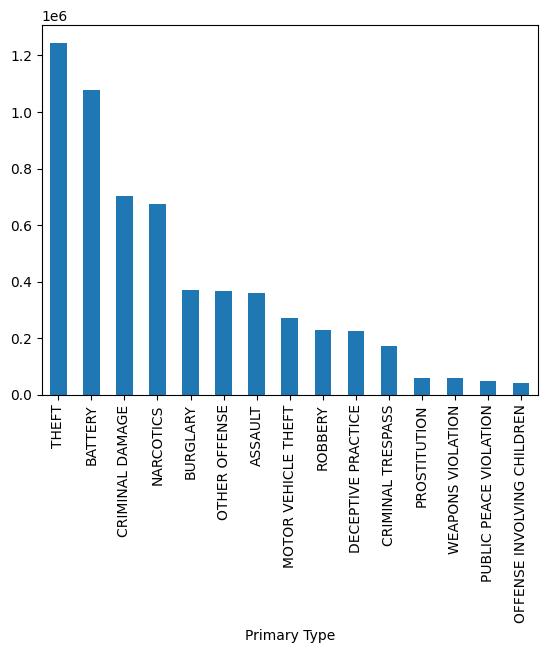

In [66]:
chicago_df['Primary Type'].value_counts().head(15).plot(kind = 'bar')
plt.show()

### 어디에서 가장 범죄가 많이 발생했는지, 범죄 장소(Location Descripton) 로 비주얼라이징 하시오.

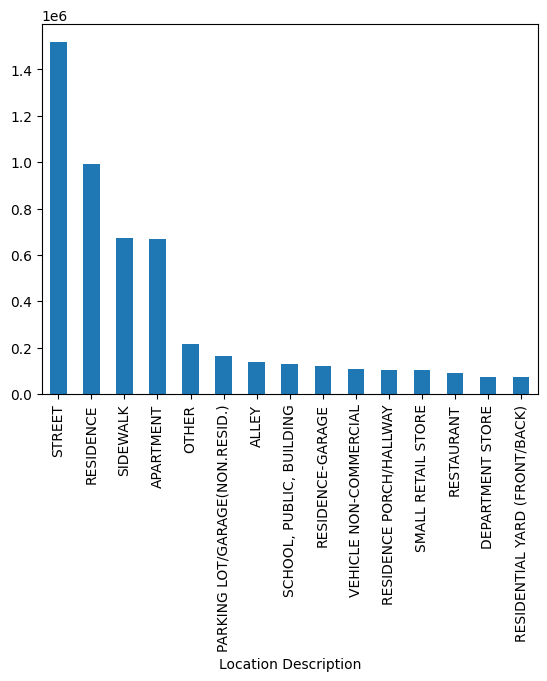

In [71]:
chicago_df['Location Description'].value_counts().head(15).plot(kind='bar')
plt.show()

### 데이터를 주기별로 분석해 보자

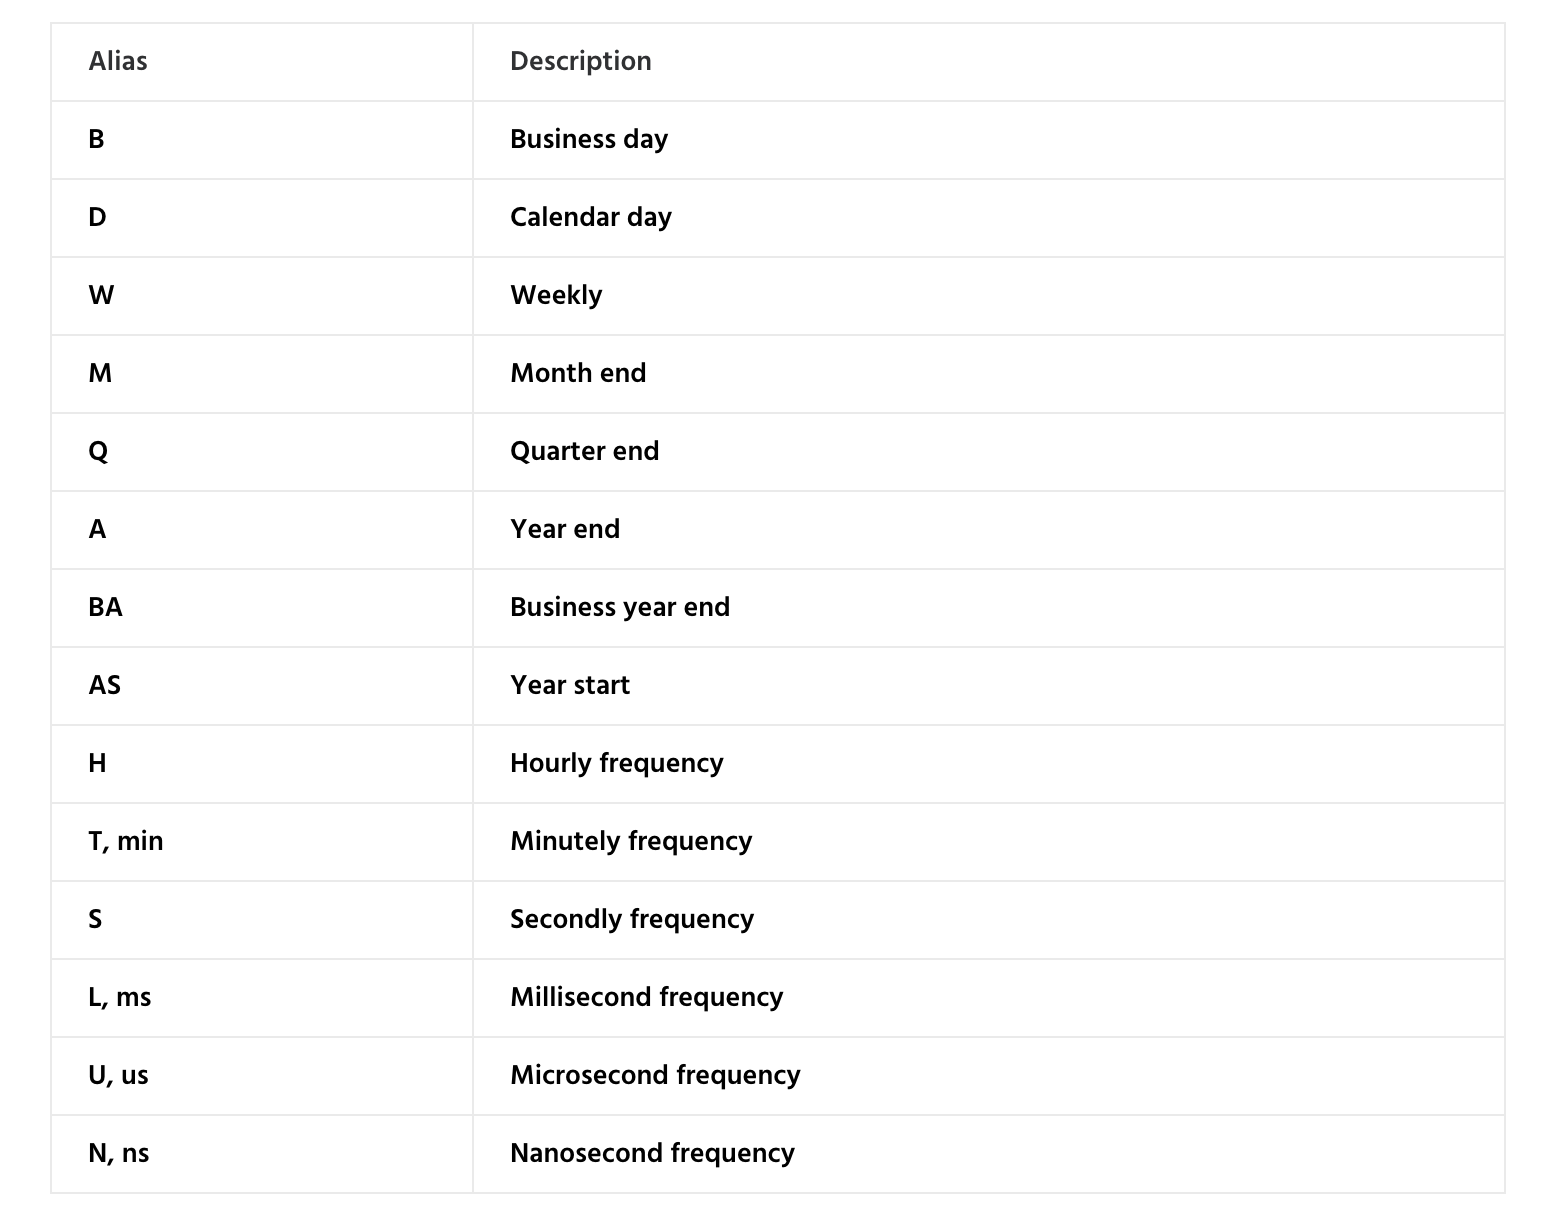

In [74]:
# resample  'Y' 는 년도다. 년도로 리샘플한 후, 각 년도별 몇개의 범죄 데이터를 가지고 있는지 확인한다.

# resample 함수를 사용하려면, 인덱스가 datetime 이어야 한다!
chicago_df.resample('Y').size()


Date
2005-12-31    455811
2006-12-31    794684
2007-12-31    621848
2008-12-31    852053
2009-12-31    783900
2010-12-31    700691
2011-12-31    352066
2012-12-31    335670
2013-12-31    306703
2014-12-31    274527
2015-12-31    262995
2016-12-31    265462
2017-12-31     11357
Freq: A-DEC, dtype: int64

In [75]:
chicago_df.resample('YS').size()

Date
2005-01-01    455811
2006-01-01    794684
2007-01-01    621848
2008-01-01    852053
2009-01-01    783900
2010-01-01    700691
2011-01-01    352066
2012-01-01    335670
2013-01-01    306703
2014-01-01    274527
2015-01-01    262995
2016-01-01    265462
2017-01-01     11357
Freq: AS-JAN, dtype: int64

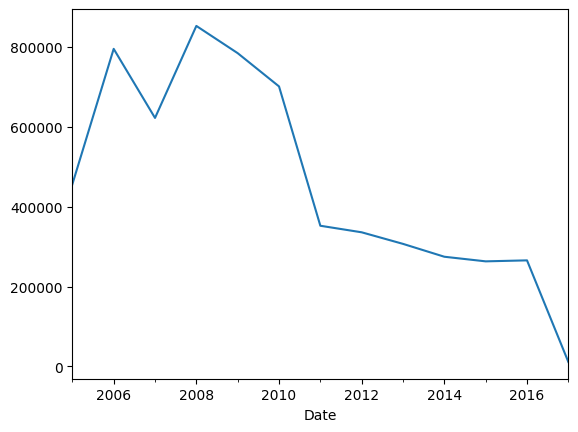

In [78]:
# 위의 데이터를 plot 으로 시각화 한다. 범죄횟수를 눈으로 확인하자.

chicago_df.resample('YS').size().plot()
plt.show()

In [79]:
# 월별 범죄 발생 건수를 확인하자.
chicago_df.resample('M').size()

Date
2005-01-31    33983
2005-02-28    32042
2005-03-31    36970
2005-04-30    38963
2005-05-31    40572
              ...  
2016-09-30    23235
2016-10-31    23314
2016-11-30    21140
2016-12-31    19580
2017-01-31    11357
Freq: M, Length: 145, dtype: int64

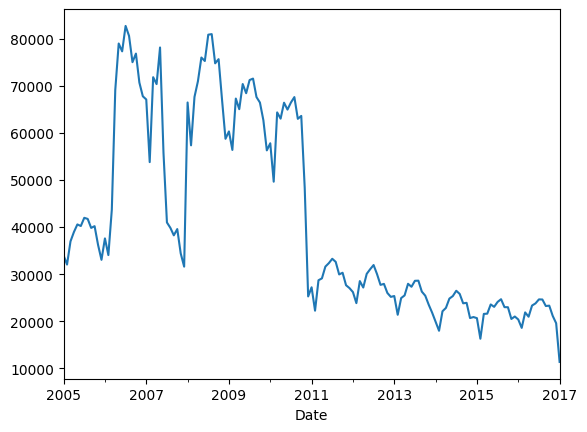

In [80]:
# 월별 범죄 발생 건수도 plot 으로 시각화 하자.
chicago_df.resample('M').size().plot()
plt.show()

In [81]:
# 분기별 범죄 건수도 확인하자.
chicago_df.resample('Q').size()

Date
2005-03-31    102995
2005-06-30    119769
2005-09-30    123550
2005-12-31    109497
2006-03-31    115389
2006-06-30    225489
2006-09-30    238423
2006-12-31    215383
2007-03-31    192791
2007-06-30    204361
2007-09-30    119086
2007-12-31    105610
2008-03-31    191523
2008-06-30    222331
2008-09-30    236695
2008-12-31    201504
2009-03-31    184055
2009-06-30    203916
2009-09-30    210446
2009-12-31    185483
2010-03-31    171848
2010-06-30    194453
2010-09-30    197116
2010-12-31    137274
2011-03-31     78167
2011-06-30     93064
2011-09-30     95835
2011-12-31     85000
2012-03-31     78574
2012-06-30     88283
2012-09-30     89685
2012-12-31     79128
2013-03-31     71651
2013-06-30     80776
2013-09-30     83510
2013-12-31     70766
2014-03-31     59964
2014-06-30     72991
2014-09-30     76090
2014-12-31     65482
2015-03-31     58503
2015-06-30     68239
2015-09-30     71782
2015-12-31     64471
2016-03-31     60843
2016-06-30     68085
2016-09-30     72500
2016-12-

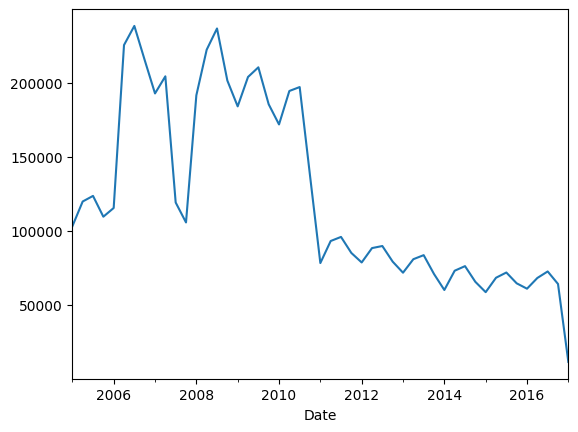

In [82]:
# 분기별 범죄 건수도 시각화 하자.
chicago_df.resample('Q').size().plot()
plt.show()

In [84]:
chicago_df.sort_index()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday,day_name
Date,,,,,,,,,,
2005-01-01 00:00:00,3837702,2005-01-01 00:00:00,021XX W JACKSON BLVD,OFFENSE INVOLVING CHILDREN,CRIM SEX ABUSE BY FAM MEMBER,APARTMENT,False,False,5,Saturday
2005-01-01 00:00:00,3731286,2005-01-01 00:00:00,018XX S SPRINGFIELD AVE,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,5,Saturday
2005-01-01 00:00:00,5497896,2005-01-01 00:00:00,005XX S LARAMIE AVE,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,APARTMENT,False,False,5,Saturday
2005-01-01 00:00:00,5139768,2005-01-01 00:00:00,015XX S HAMLIN AVE,CRIM SEXUAL ASSAULT,PREDATORY,APARTMENT,True,True,5,Saturday
2005-01-01 00:00:00,4710921,2005-01-01 00:00:00,067XX S NORMAL BLVD,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,5,Saturday
...,...,...,...,...,...,...,...,...,...,...
2017-01-18 23:30:00,10820633,2017-01-18 23:30:00,116XX S LOWE AVE,BATTERY,DOMESTIC BATTERY SIMPLE,SIDEWALK,False,True,2,Wednesday
2017-01-18 23:35:00,10820662,2017-01-18 23:35:00,028XX W SHAKESPEARE AVE,ROBBERY,VEHICULAR HIJACKING,ALLEY,False,False,2,Wednesday
2017-01-18 23:40:00,10821699,2017-01-18 23:40:00,010XX W WILSON AVE,ROBBERY,ARMED: HANDGUN,STREET,False,False,2,Wednesday


In [ ]:
# 범죄 발생 건수를 예측하고 싶다!!

In [85]:
chicago_df

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,weekday,day_name
Date,,,,,,,,,,
2006-04-02 13:00:00,4673626,2006-04-02 13:00:00,055XX N MANGO AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,False,6,Sunday
2006-02-26 13:40:48,4673627,2006-02-26 13:40:48,065XX S RHODES AVE,NARCOTICS,MANU/DELIVER:CRACK,SIDEWALK,True,False,6,Sunday
2006-01-08 23:16:00,4673628,2006-01-08 23:16:00,013XX E 69TH ST,ASSAULT,AGGRAVATED: HANDGUN,OTHER,False,False,6,Sunday
2006-04-05 18:45:00,4673629,2006-04-05 18:45:00,061XX W NEWPORT AVE,BATTERY,SIMPLE,RESIDENCE,False,False,2,Wednesday
2006-02-17 21:03:14,4673630,2006-02-17 21:03:14,037XX W 60TH ST,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,ALLEY,True,False,4,Friday
...,...,...,...,...,...,...,...,...,...,...
2016-05-03 23:33:00,10508679,2016-05-03 23:33:00,026XX W 23RD PL,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1,Tuesday
2016-05-03 23:30:00,10508680,2016-05-03 23:30:00,073XX S HARVARD AVE,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,True,True,1,Tuesday
2016-05-03 00:15:00,10508681,2016-05-03 00:15:00,024XX W 63RD ST,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,1,Tuesday


# STEP #3: 데이터 준비

In [90]:
df_prophet = chicago_df.resample('D').size().to_frame().reset_index().rename(columns={'Date':'ds', 0:'y'})

In [91]:
prophet = Prophet()

In [92]:
prophet.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprprk5bpd/yl834n62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprprk5bpd/vf0f8m3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59480', 'data', 'file=/tmp/tmprprk5bpd/yl834n62.json', 'init=/tmp/tmprprk5bpd/vf0f8m3g.json', 'output', 'file=/tmp/tmprprk5bpd/prophet_modelkmp4trcc/prophet_model-20240419065615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:56:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:56:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [93]:
future = prophet.make_future_dataframe(periods=365, freq='D')

In [95]:
forecast = prophet.predict(future)

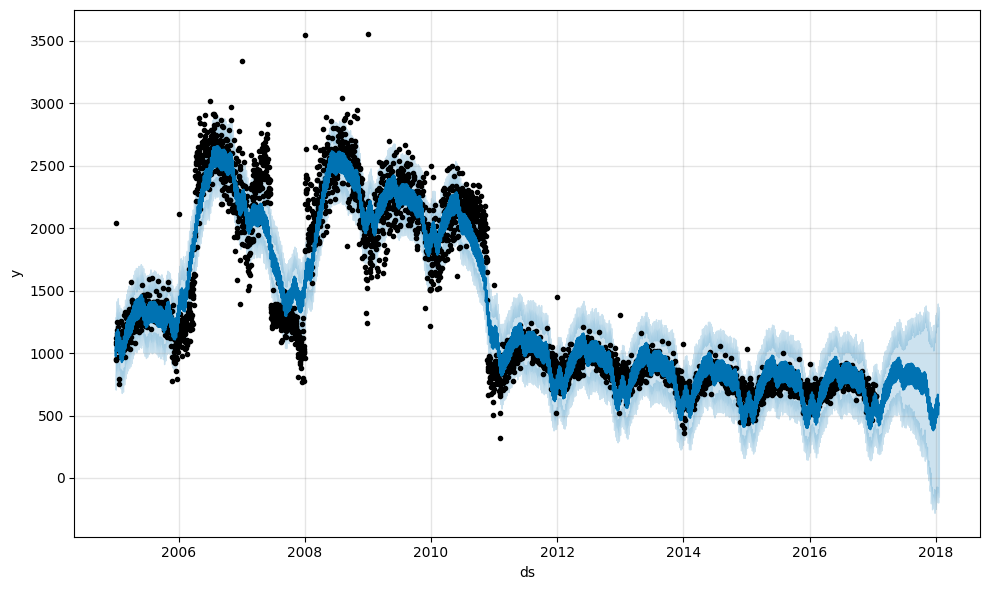

In [96]:
prophet.plot(forecast)
plt.savefig('chart1.png')

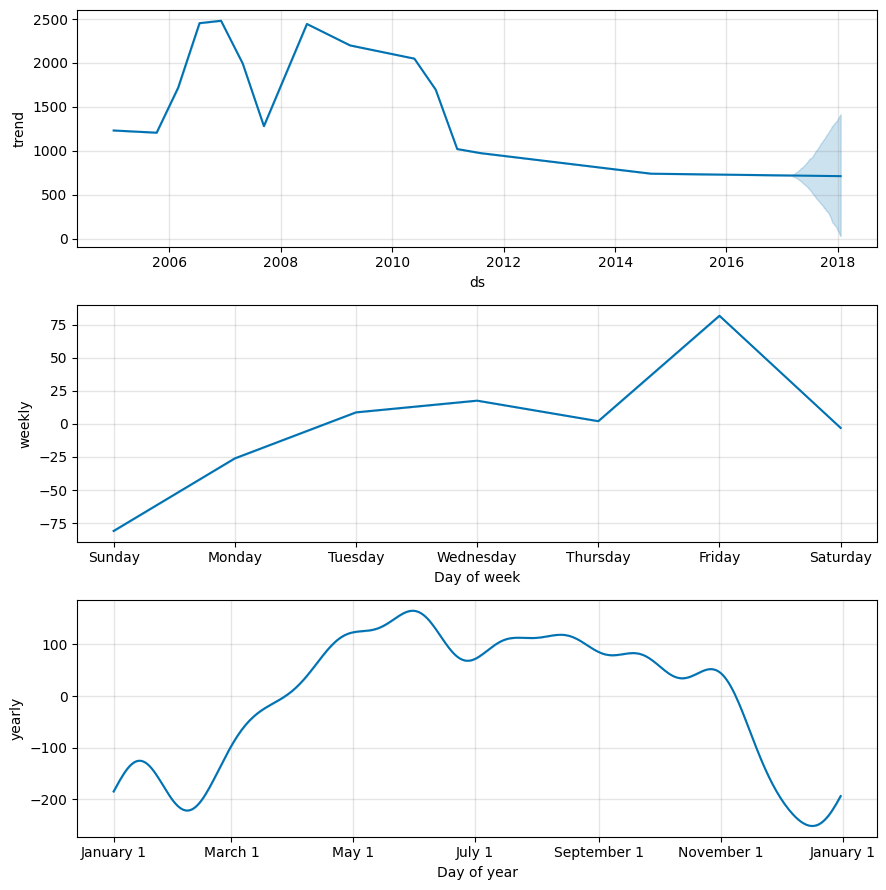

In [97]:
prophet.plot_components(forecast)
plt.savefig('chart2.png')

### 원별로(매달 말일) 주기로 하여 데이터프레임을 만들고, 인덱스를 리셋하시오.

In [ ]:
chicago_prophet =

### 프로펫 라이브러리를 사용하려면, 날짜 컬럼은 'ds' 로, 에측하려는 수치는 'y'로 바꿔야 합니다(필수).

# STEP #4: Prophet 으로 예측하기

### [freq 조절 가능한 문자 ](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases)

[페이스북 프로펫 페이지 예시](https://facebook.github.io/prophet/docs/non-daily_data.html)

In [ ]:
# 36개월로 해서 예측해보자.
